<!-- DPI2-00-HEADER-00 -->

# D-PI-2 Escalation Threshold
## Medicare Program Integrity Decision Support Framework

**Module:** D-PI-2  
**Decision type:** Escalation pathway assignment  
**Decision owner:** Investigations Lead / UPIC Case Development Manager  
**Status:** IN PROGRESS  
**Last updated:** 2026-02-23  

---

### Purpose

This notebook scores the 500 Tier 1 providers identified by D-PI-1 across four
risk dimensions and assigns each provider to one of three CMS/UPIC escalation
pathways based on a weighted composite score.

This analysis supports program integrity review decisions. It does not assert,
imply, or conclude that any provider committed fraud, abuse, or intentional
wrongdoing. All outputs are analytical decision-support tools only.

---

### Inputs

| File | Source | Description |
|---|---|---|
| `provider_review_queue_v1.parquet` | D-PI-1 output | 500 Tier 1 providers, dollar-ranked |
| `provider_signal_scores_v1.parquet` | D-PI-1 output | 8 signals per provider (S1–S7, S5a/S5b) |
| `provider_rollup_v1.parquet` | D-PI-1 output | Allowed dollars, payments, beneficiary counts |
| `provider_tiered_v1.parquet` | D-PI-1 output | Full 970,848 provider set (peer group source) |

---

### Outputs

| File | Description |
|---|---|
| `escalation_scored_v1.parquet` | 500 providers with D1–D4 dimension scores and composite score |
| `escalation_pathway_v1.parquet` | 500 providers with pathway assignments and supporting rationale |

---

### Four Scoring Dimensions

| Dimension | Weight | Description |
|---|---|---|
| D1 Signal Breadth | 0.25 | Flagged signal count / 8 |
| D2 Signal Type Composition | 0.30 | Weighted toward high-concern signals S4, S5a, S5b |
| D3 Peer-Relative Dollar Exposure | 0.25 | Allowed dollars vs. Provider Type peer median |
| D4 Signal Persistence | 0.20 | Re-scored against State × RUCA subgroups |

---

### Three Escalation Pathways

| Pathway | Composite Score | Description |
|---|---|---|
| OIG/DOJ Referral | ≥ 0.75 (provisional) | Highest composite risk — referral recommended |
| Targeted Probe and Educate (TPE) | ≥ 0.50 (provisional) | Elevated risk — targeted review warranted |
| Provider Education Letter | < 0.50 (provisional) | Lower composite risk — educational response |

> **Note:** Pathway thresholds are provisional pending score distribution
> analysis in cell DPI2-07-VIZ-01. All thresholds will be recalibrated
> before this module is marked COMPLETE.

---

### Output Classification

All outputs are tagged using the O/D/I/A framework:

| Tag | Meaning |
|---|---|
| O | Observed — direct value from the data |
| D | Derived — calculated from observed values |
| I | Inferred — reasoned from patterns |
| A | Assumed — design decision without data confirmation |

---

### Data Source

CMS Medicare Part B 2023 Provider and Services Utilization file  
`MUP_PHY_R25_PD5_V20_D23_prov_svc.csv` — 970,848 providers processed by D-PI-1

In [53]:
# DPI2-00-CONFIG-01
# D-PI-2 Escalation Threshold — Configuration and Parameters
# All thresholds, weights, paths, and palette values defined here.
# No hardcoded variables anywhere else in this notebook.
# ---------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path

# ---------------------------------------------------------------
# PATHS
# ---------------------------------------------------------------
BASE_DIR    = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
DATA_IN     = BASE_DIR / "data" / "processed"
DATA_OUT    = BASE_DIR / "data" / "processed"
FIG_OUT     = BASE_DIR / "outputs" / "figures"
BRIEF_OUT   = BASE_DIR / "outputs" / "decision_briefs"

# ---------------------------------------------------------------
# INPUT FILES (outputs from D-PI-1)
# ---------------------------------------------------------------
F_QUEUE     = DATA_IN / "provider_review_queue_v1.parquet"   # 500 Tier 1 providers
F_SIGNALS   = DATA_IN / "provider_signal_scores_v1.parquet"  # 8 signals per provider
F_ROLLUP    = DATA_IN / "provider_rollup_v1.parquet"         # dollars, payments, benes
F_TIERED    = DATA_IN / "provider_tiered_v1.parquet"         # full 970,848 provider set
F_INTERIM   = BASE_DIR / "data" / "interim" / "partb_provider_service.parquet"  # raw NPI-service rows; source of state and RUCA
# ---------------------------------------------------------------
# OUTPUT FILES
# ---------------------------------------------------------------
F_SCORED    = DATA_OUT / "escalation_scored_v1.parquet"      # D-PI-2 scored providers
F_PATHWAY   = DATA_OUT / "escalation_pathway_v1.parquet"     # pathway assignments

# ---------------------------------------------------------------
# REPRODUCIBILITY
# ---------------------------------------------------------------
RANDOM_STATE = 42   # Industry-standard reproducibility seed

# ---------------------------------------------------------------
# POPULATION FILTER
# Rationale: Inherited from D-PI-1. CMS statistical reliability
# standard — suppress providers with fewer than 50 beneficiaries
# to avoid small-sample distortion.
# ---------------------------------------------------------------
MIN_BENE_THRESHOLD = 50

# ---------------------------------------------------------------
# PEER GROUP
# Rationale: State × RUCA subgroup captures both geographic and
# urban/rural variation in billing norms. Provider Type used for
# D3 dollar exposure peer comparison.
# Min subgroup size: below this, peer comparison is statistically
# unreliable — assign neutral score 0.50 instead.
# ---------------------------------------------------------------
MIN_SUBGROUP_SIZE  = 10
NEUTRAL_SCORE      = 0.50

# ---------------------------------------------------------------
# DIMENSION WEIGHTS
# Must sum to 1.0
# Rationale:
#   D1 Signal Breadth     (0.25) — breadth of concern across signal set
#   D2 Signal Composition (0.30) — highest weight; high-concern signal
#                                  types S4, S5a, S5b carry most risk
#   D3 Dollar Exposure    (0.25) — financial magnitude vs. peer median
#   D4 Signal Persistence (0.20) — cross-subgroup consistency check
# ---------------------------------------------------------------
W_D1 = 0.25   # Signal Breadth
W_D2 = 0.30   # Signal Type Composition
W_D3 = 0.25   # Peer-Relative Dollar Exposure
W_D4 = 0.20   # Signal Persistence

assert abs((W_D1 + W_D2 + W_D3 + W_D4) - 1.0) < 1e-9, \
    "Dimension weights must sum to 1.0"

# ---------------------------------------------------------------
# SIGNAL DEFINITIONS
# Total signals: 8 (S1, S2, S3, S4, S5a, S5b, S6, S7)
# High-concern signals used in D2 composition score
# Rationale: S4 (billing concentration), S5a/S5b (peer outlier
# patterns) are most strongly associated with program integrity
# concerns per CMS/OIG guidance.
# ---------------------------------------------------------------
TOTAL_SIGNALS       = 8
HIGH_CONCERN        = ['S4', 'S5a', 'S5b']   # D2 elevated-weight signals
STANDARD_SIGNALS    = ['S1', 'S2', 'S3', 'S6', 'S7']

# D2 signal weights within composition score
# High-concern signals weighted 2x standard signals
# Rationale: Reflects CMS program integrity prioritization
D2_WEIGHT_HIGH      = 2.0   # weight multiplier for HIGH_CONCERN signals
D2_WEIGHT_STANDARD  = 1.0   # weight multiplier for STANDARD_SIGNALS

# Maximum possible D2 weighted score (for normalization)
D2_MAX = (len(HIGH_CONCERN) * D2_WEIGHT_HIGH) + \
         (len(STANDARD_SIGNALS) * D2_WEIGHT_STANDARD)
         
# ---------------------------------------------------------------
# SCORING PARAMETERS
# ---------------------------------------------------------------
CORE_Z_THRESHOLD = 2.0   # Inherited from D-PI-1 signal engine
                         # Rationale: Standard statistical threshold
                         # for anomaly detection; a signal is considered
                         # flagged when peer-adjusted Z-score >= this value

D3_CAP = 5.0             # FINALIZED — D3 peer-relative dollar exposure ceiling
                         # Rationale: 99.5% of Tier 1 providers fall below 5x peer median;
                         # only 108 of 22,400 providers capped (0.5%); max raw ratio 55x
                         # confirms extreme outliers exist but are isolated; cap preserves
                         # resolution across the operationally meaningful 1x-5x range.
                         # Tag: D (Derived) — confirmed from distribution analysis 2026-02-24.

# ---------------------------------------------------------------
# DIAGNOSTIC PERCENTILES
# Used in score distribution reporting — no decision logic attached.
# Rationale: Selected to bracket the operationally relevant range
# and inform provisional threshold calibration at DPI2-07-VIZ-01.
# ---------------------------------------------------------------
SCORE_PERCENTILES = [50, 60, 70, 75, 80, 85, 90, 95, 99]                         

# ---------------------------------------------------------------
# PATHWAY THRESHOLDS — CALIBRATED
# Rationale: Derived from composite score distribution analysis
# in DPI2-07-VIZ-01. Natural breaks identified at 0.40 and 0.50.
# THRESHOLD_TPE (0.40) separates the main provider body from the
# thinning shoulder — approximately p90 of the Tier 1 population.
# THRESHOLD_OIG (0.50) separates the shoulder from the isolated
# right tail — approximately p99 of the Tier 1 population.
# Tag: D (Derived) — calibrated from distribution analysis.
# ---------------------------------------------------------------
THRESHOLD_OIG = 0.50   # composite >= this → OIG/DOJ Referral
THRESHOLD_TPE = 0.40   # composite >= this and < OIG → Targeted Probe and Educate
                       # composite <  this → Provider Education Letter

# ---------------------------------------------------------------
# CVD-COMPLIANT PALETTE (IBM Carbon)
# Readable by individuals with color vision deficiency.
# Use CVD_PALETTE keys everywhere — no inline color strings.
# ---------------------------------------------------------------
CVD_PALETTE = {
    'tier1_oig'   : '#DC267F',   # Magenta — OIG/DOJ Referral
    'tier2_tpe'   : '#FFB000',   # Amber   — Targeted Probe and Educate
    'tier3_edltr' : '#648FFF',   # Blue    — Provider Education Letter
    'no_flag'     : '#BBBBBB',   # Gray    — No flag / neutral
}

# ---------------------------------------------------------------
# CONFIRM CONFIG LOADED
# ---------------------------------------------------------------
print("DPI2-00-CONFIG-01 loaded successfully")
print(f"  Dimension weights : D1={W_D1} | D2={W_D2} | D3={W_D3} | D4={W_D4} | Sum={W_D1+W_D2+W_D3+W_D4}")
print(f"  D2 max score      : {D2_MAX}")
print(f"  Pathway thresholds: OIG>={THRESHOLD_OIG} | TPE>={THRESHOLD_TPE} [CALIBRATED]")
print(f"  Min bene threshold: {MIN_BENE_THRESHOLD}")
print(f"  Min subgroup size : {MIN_SUBGROUP_SIZE}")
print(f"  Neutral score     : {NEUTRAL_SCORE}")
print(f"  Random state      : {RANDOM_STATE}")
print(f"  Input path        : {DATA_IN}")
print(f"  Output path       : {DATA_OUT}")
print(f"  Core Z threshold  : {CORE_Z_THRESHOLD}")
print(f"  D3 cap            : {D3_CAP}  [FINALIZED — confirmed by diagnostic distribution analysis]")

DPI2-00-CONFIG-01 loaded successfully
  Dimension weights : D1=0.25 | D2=0.3 | D3=0.25 | D4=0.2 | Sum=1.0
  D2 max score      : 11.0
  Pathway thresholds: OIG>=0.5 | TPE>=0.4 [CALIBRATED]
  Min bene threshold: 50
  Min subgroup size : 10
  Neutral score     : 0.5
  Random state      : 42
  Input path        : C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed
  Output path       : C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed
  Core Z threshold  : 2.0
  D3 cap            : 5.0  [FINALIZED — confirmed by diagnostic distribution analysis]


<!-- DPI2-01-LOAD-00 -->

## Section 1 — Data Load

Loads all four D-PI-1 output files into memory and confirms expected
row counts before any processing begins. No transformations occur in
this section — load only.

Expected populations:
- **Review queue:** 500 providers (Tier 1 only)
- **Signal scores:** 500 providers (Tier 1 only, joined from queue)
- **Rollup:** 970,848 providers (full population — peer group source)
- **Tiered:** 970,848 providers (full population — peer group source)

In [25]:
# DPI2-01-LOAD-01
# Load all D-PI-1 output files
# No transformations — load and confirm only
# ---------------------------------------------------------------

# Load Tier 1 review queue (500 providers, dollar-ranked)
df_queue = pd.read_parquet(F_QUEUE)

# Load signal scores (8 signals per provider)
df_signals = pd.read_parquet(F_SIGNALS)

# Load provider rollup (allowed dollars, payments, bene counts)
df_rollup = pd.read_parquet(F_ROLLUP)

# Load full tiered provider set (970,848 — peer group source)
df_tiered = pd.read_parquet(F_TIERED)

# ---------------------------------------------------------------
# CONFIRM ROW COUNTS
# ---------------------------------------------------------------
print("DPI2-01-LOAD-01 — File load confirmation")
print("-" * 50)
print(f"  df_queue   : {len(df_queue):>10,} rows  | expected:        22,400")
print(f"  df_signals : {len(df_signals):>10,} rows  | expected: 970,848")
print(f"  df_rollup  : {len(df_rollup):>10,} rows  | expected:   1,175,281")
print(f"  df_tiered  : {len(df_tiered):>10,} rows  | expected:    970,848")
print()

# ---------------------------------------------------------------
# CONFIRM QUEUE ROW COUNT EXACTLY
# ---------------------------------------------------------------
assert len(df_queue) == 22_400, \
    f"df_queue expected 22,400 rows, got {len(df_queue)}"

assert len(df_rollup) > 900_000, \
    f"df_rollup unexpectedly small: {len(df_rollup)} rows"

assert len(df_tiered) > 900_000, \
    f"df_tiered unexpectedly small: {len(df_tiered)} rows"

# ---------------------------------------------------------------
# CONFIRM COLUMN PRESENCE
# ---------------------------------------------------------------
print("Column inventory:")
print(f"  df_queue   : {list(df_queue.columns)}")
print(f"  df_signals : {list(df_signals.columns)}")
print(f"  df_rollup  : {list(df_rollup.columns)}")
print(f"  df_tiered  : {list(df_tiered.columns)}")
print()
print("DPI2-01-LOAD-01 complete — all files loaded")

DPI2-01-LOAD-01 — File load confirmation
--------------------------------------------------
  df_queue   :     22,400 rows  | expected:        22,400
  df_signals :    970,848 rows  | expected: 970,848
  df_rollup  :  1,175,281 rows  | expected:   1,175,281
  df_tiered  :    970,848 rows  | expected:    970,848

Column inventory:
  df_queue   : ['review_rank', 'Rndrng_NPI', 'Rndrng_Prvdr_Type', 'Tot_Benes_sum', 'Tot_Srvcs_sum', 'allowed_dollars_sum', 'payment_dollars_sum', 'signals_flagged', 'anomaly_tier', 'S1_allowed_per_bene_zscore', 'S2_payment_per_bene_zscore', 'S3_services_per_bene_zscore', 'S4_submitted_to_allowed_ratio_zscore', 'S5a_top1_allowed_share_zscore', 'S5b_top1_payment_share_zscore', 'S6_payment_to_allowed_ratio_zscore', 'S7_allowed_minus_payment_per_bene_zscore']
  df_signals : ['Rndrng_NPI', 'Rndrng_Prvdr_Type', 'Tot_Benes_sum', 'Tot_Srvcs_sum', 'allowed_dollars_sum', 'payment_dollars_sum', 'submitted_dollars_sum', 'S3_services_per_bene', 'S1_allowed_per_bene', 'S2_p

<!-- DPI2-02-VALIDATE-00 -->

## Section 2 — Data Validation

Confirms data integrity across all four loaded files before any
processing begins. Checks performed:

- No duplicate NPIs in the Tier 1 queue
- All 22,400 queue providers have matching signal records in df_signals
- No null values in columns required for scoring
- Beneficiary threshold enforcement (>= 50 beneficiaries)
- Signal flag columns contain only 0/1 values
- All z-score columns present and numeric

In [26]:
# DPI2-02-VALIDATE-01
# Data integrity checks — all must pass before scoring begins
# Null z-scores in S6 and S7 (107 providers each) treated as 0
# Rationale: null z-score means signal could not be calculated
# (likely zero denominator), not that signal fired negatively.
# Treatment: signal did not fire — score contribution = 0 (A)
# ---------------------------------------------------------------

print("DPI2-02-VALIDATE-01 — Data validation")
print("-" * 50)

# ---------------------------------------------------------------
# CHECK 1 — No duplicate NPIs in queue
# ---------------------------------------------------------------
queue_dupes = df_queue['Rndrng_NPI'].duplicated().sum()
print(f"  CHECK 1 — Duplicate NPIs in queue       : {queue_dupes} {'PASS' if queue_dupes == 0 else 'FAIL'}")

# ---------------------------------------------------------------
# CHECK 2 — All queue NPIs exist in df_signals
# ---------------------------------------------------------------
queue_npis   = set(df_queue['Rndrng_NPI'])
signal_npis  = set(df_signals['Rndrng_NPI'])
missing_npis = queue_npis - signal_npis
print(f"  CHECK 2 — Queue NPIs missing in signals : {len(missing_npis)} {'PASS' if len(missing_npis) == 0 else 'FAIL'}")

# ---------------------------------------------------------------
# CHECK 3 — Null z-scores in S6 and S7 only (expected: 107 each)
# All other scoring columns must be null-free
# ---------------------------------------------------------------
exempt_nulls = ['S6_payment_to_allowed_ratio_zscore',
                'S7_allowed_minus_payment_per_bene_zscore']
non_exempt_cols = [c for c in queue_score_cols if c not in exempt_nulls]
non_exempt_nulls = df_queue[non_exempt_cols].isnull().sum().sum()
s6_nulls = df_queue['S6_payment_to_allowed_ratio_zscore'].isnull().sum()
s7_nulls = df_queue['S7_allowed_minus_payment_per_bene_zscore'].isnull().sum()
print(f"  CHECK 3a — Nulls in non-exempt columns  : {non_exempt_nulls} {'PASS' if non_exempt_nulls == 0 else 'FAIL'}")
print(f"  CHECK 3b — S6 null count                : {s6_nulls} (expected: 107) {'PASS' if s6_nulls == 107 else 'WARNING'}")
print(f"  CHECK 3c — S7 null count                : {s7_nulls} (expected: 107) {'PASS' if s7_nulls == 107 else 'WARNING'}")

# ---------------------------------------------------------------
# CHECK 4 — Beneficiary threshold enforcement
# ---------------------------------------------------------------
below_threshold = (df_queue['Tot_Benes_sum'] < MIN_BENE_THRESHOLD).sum()
print(f"  CHECK 4 — Providers below bene threshold: {below_threshold} {'PASS' if below_threshold == 0 else 'WARNING — review required'}")

# ---------------------------------------------------------------
# CHECK 5 — signals_flagged range (must be 3-8 for Tier1)
# ---------------------------------------------------------------
sig_min = df_queue['signals_flagged'].min()
sig_max = df_queue['signals_flagged'].max()
sig_valid = (sig_min >= 3) and (sig_max <= TOTAL_SIGNALS)
print(f"  CHECK 5 — signals_flagged range         : {sig_min}-{sig_max} {'PASS' if sig_valid else 'FAIL'}")

# ---------------------------------------------------------------
# CHECK 6 — All queue providers are Tier1_Review
# ---------------------------------------------------------------
non_tier1 = (df_queue['anomaly_tier'] != 'Tier1_Review').sum()
print(f"  CHECK 6 — Non-Tier1 rows in queue       : {non_tier1} {'PASS' if non_tier1 == 0 else 'FAIL'}")

print()

# ---------------------------------------------------------------
# FILL NULL Z-SCORES WITH 0 BEFORE SCORING
# Rationale: signal did not fire — treat as no contribution (A)
# ---------------------------------------------------------------
df_queue['S6_payment_to_allowed_ratio_zscore'] = \
    df_queue['S6_payment_to_allowed_ratio_zscore'].fillna(0)
df_queue['S7_allowed_minus_payment_per_bene_zscore'] = \
    df_queue['S7_allowed_minus_payment_per_bene_zscore'].fillna(0)

print(f"  NULL FILL — S6 nulls remaining          : {df_queue['S6_payment_to_allowed_ratio_zscore'].isnull().sum()} PASS")
print(f"  NULL FILL — S7 nulls remaining          : {df_queue['S7_allowed_minus_payment_per_bene_zscore'].isnull().sum()} PASS")
print()

# ---------------------------------------------------------------
# ASSERT ALL CRITICAL CHECKS PASSED
# ---------------------------------------------------------------
assert queue_dupes       == 0,  f"Duplicate NPIs in queue: {queue_dupes}"
assert len(missing_npis) == 0,  f"Queue NPIs missing in signals: {len(missing_npis)}"
assert non_exempt_nulls  == 0,  f"Nulls in non-exempt scoring columns: {non_exempt_nulls}"
assert sig_valid,               f"signals_flagged out of range: {sig_min}-{sig_max}"
assert non_tier1         == 0,  f"Non-Tier1 rows in queue: {non_tier1}"

print("DPI2-02-VALIDATE-01 complete — all critical checks passed")

DPI2-02-VALIDATE-01 — Data validation
--------------------------------------------------
  CHECK 1 — Duplicate NPIs in queue       : 0 PASS
  CHECK 2 — Queue NPIs missing in signals : 0 PASS
  CHECK 3a — Nulls in non-exempt columns  : 0 PASS
  CHECK 3b — S6 null count                : 107 (expected: 107) PASS
  CHECK 3c — S7 null count                : 107 (expected: 107) PASS
  CHECK 4 — Providers below bene threshold: 0 PASS
  CHECK 5 — signals_flagged range         : 3-7 PASS
  CHECK 6 — Non-Tier1 rows in queue       : 0 PASS

  NULL FILL — S6 nulls remaining          : 0 PASS
  NULL FILL — S7 nulls remaining          : 0 PASS

DPI2-02-VALIDATE-01 complete — all critical checks passed


<!-- DPI2-03-PREP-00 -->
## Section 03 — Feature Engineering

This section constructs the four dimension scoring inputs (D1–D4) from the
merged working dataset produced in Section 01–02.

No scoring occurs here. This section produces only the intermediate feature
columns that Section 05 (SCORE) will consume.

**Dimension inputs built in this section:**

| Dimension | Input Feature | Source |
|---|---|---|
| D1 — Signal Breadth | `d1_signal_breadth` | flagged_signal_count / 8 |
| D2 — Signal Type Composition | `d2_signal_type_score` | high-concern signal presence (S4, S5a, S5b) |
| D3 — Peer-Relative Dollar Exposure | `d3_dollar_exposure` | allowed dollars vs. Provider Type peer median |
| D4 — Signal Persistence | `d4_persistence_score` | re-scored Z-scores against State × RUCA subgroups |

All features are normalized to [0, 1].
Subgroups below `MIN_SUBGROUP_SIZE` receive a neutral score of 0.50 (tagged A).

<!-- DPI2-03-PREP-00 -->
## Section 03 — Feature Engineering

This section builds the D-PI-2 working dataset and constructs the four
dimension scoring inputs (D1–D4).

**03-PREP-00** — Build `df_work`: merge `df_queue` with signal scores,
rollup dollars, and peer group context from `df_tiered`.

**03-PREP-01** — Engineer D1–D4 feature columns from `df_work`.

No composite scoring occurs here. All features are normalized to [0, 1].
Subgroups below `MIN_SUBGROUP_SIZE` receive neutral score 0.50 (tagged A).

| Dimension | Feature Column | Construction |
|---|---|---|
| D1 — Signal Breadth | `d1_signal_breadth` | signals_flagged / TOTAL_SIGNALS |
| D2 — Signal Type Composition | `d2_signal_type_score` | high-concern signal flags (S4, S5a, S5b) |
| D3 — Peer-Relative Dollar Exposure | `d3_dollar_exposure` | allowed per bene vs. Provider Type peer median |
| D4 — Signal Persistence | `d4_persistence_score` | Z-scores re-evaluated vs. State × RUCA subgroup |

In [32]:
# DPI2-03-PREP-00a
# Build df_work — D-PI-2 working dataset
# ---------------------------------------------------------------
# df_queue already contains all 8 Z-scores and signals_flagged.
# No merge from df_signals or df_tiered needed for scoring columns.
#
# What df_queue is missing and must be joined from interim parquet:
#   - Rndrng_Prvdr_State_Abrvtn  (for D4 State × RUCA subgroup)
#   - Rndrng_Prvdr_RUCA          (for D4 State × RUCA subgroup)
#
# Note: ruca_cat was never written to any processed file.
# Raw Rndrng_Prvdr_RUCA used directly — consistent with
# peer_group_contract v1 secondary controls.
# ---------------------------------------------------------------

print("DPI2-03-PREP-00a — Building df_work")
print("-" * 50)

# ── Step 1: Load state + RUCA lookup from interim parquet ────────
# Interim parquet is partitioned (39 fragments, Dask-written).
# pd.read_parquet handles partitioned directories natively.
# Aggregate to NPI level — state and RUCA are provider attributes
# and should not vary across service rows. Take first value per NPI.

interim_cols = ['Rndrng_NPI',
                'Rndrng_Prvdr_State_Abrvtn',
                'Rndrng_Prvdr_RUCA']

df_geo = (
    pd.read_parquet(F_INTERIM, columns=interim_cols)
    .groupby('Rndrng_NPI', as_index=False)
    .first()
)

print(f"  df_geo loaded     : {len(df_geo):,} unique NPIs from interim parquet")

# ── Step 2: Start df_work from df_queue ──────────────────────────
df_work = df_queue.copy()

# ── Step 3: Join state + RUCA onto df_work ───────────────────────
df_work = df_work.merge(
    df_geo[['Rndrng_NPI',
            'Rndrng_Prvdr_State_Abrvtn',
            'Rndrng_Prvdr_RUCA']],
    on='Rndrng_NPI',
    how='left'
)

# ── Step 4: Confirm shape and required columns ───────────────────
required_cols = [
    'Rndrng_NPI',
    'Rndrng_Prvdr_Type',
    'signals_flagged',
    'allowed_dollars_sum',
    'Tot_Benes_sum',
    'Rndrng_Prvdr_State_Abrvtn',
    'Rndrng_Prvdr_RUCA',
    'S1_allowed_per_bene_zscore',
    'S2_payment_per_bene_zscore',
    'S3_services_per_bene_zscore',
    'S4_submitted_to_allowed_ratio_zscore',
    'S5a_top1_allowed_share_zscore',
    'S5b_top1_payment_share_zscore',
    'S6_payment_to_allowed_ratio_zscore',
    'S7_allowed_minus_payment_per_bene_zscore',
]

missing_cols = [c for c in required_cols if c not in df_work.columns]
assert len(missing_cols) == 0, f"Missing columns in df_work: {missing_cols}"
assert len(df_work) == len(df_queue), \
    f"Row count changed after merge: expected {len(df_queue)}, got {len(df_work)}"

# ── Step 5: Report geo nulls ─────────────────────────────────────
geo_nulls = df_work['Rndrng_Prvdr_State_Abrvtn'].isnull().sum()
print(f"  df_work rows      : {len(df_work):,}  (expected: 22,400)")
print(f"  Columns present   : {len(df_work.columns)}")
print(f"  Geo nulls (state) : {geo_nulls}  (expected: 0)")

if geo_nulls > 0:
    print(f"  WARNING — {geo_nulls} providers unmatched in geo join.")
    print(f"  These will receive NEUTRAL_SCORE={NEUTRAL_SCORE} in D4.")

print()
print("DPI2-03-PREP-00a complete — df_work ready for feature engineering")

DPI2-03-PREP-00a — Building df_work
--------------------------------------------------
  df_geo loaded     : 1,175,281 unique NPIs from interim parquet
  df_work rows      : 22,400  (expected: 22,400)
  Columns present   : 19
  Geo nulls (state) : 0  (expected: 0)

DPI2-03-PREP-00a complete — df_work ready for feature engineering


In [40]:
# DPI2-03-PREP-01
# Feature engineering — D1 through D4 dimension scoring inputs
# Produces intermediate columns consumed by DPI2-05-SCORE-01
# No composite scoring here — feature construction only
# ---------------------------------------------------------------

Z_COLS = [
    'S1_allowed_per_bene_zscore',
    'S2_payment_per_bene_zscore',
    'S3_services_per_bene_zscore',
    'S4_submitted_to_allowed_ratio_zscore',
    'S5a_top1_allowed_share_zscore',
    'S5b_top1_payment_share_zscore',
    'S6_payment_to_allowed_ratio_zscore',
    'S7_allowed_minus_payment_per_bene_zscore',
]

# ── D1 : Signal Breadth ───────────────────────────────────────────
# Ratio of flagged signals to total signals (8).
# Ranges [0, 1] naturally. No normalization required.
# Source: signals_flagged already computed in D-PI-1 signal engine.

df_work['d1_signal_breadth'] = df_work['signals_flagged'] / TOTAL_SIGNALS

# ── D2 : Signal Type Composition ─────────────────────────────────
# Weighted presence of high-concern vs. standard signals.
# High-concern (S4, S5a, S5b) weighted 2x standard signals.
# Score = weighted flagged count / D2_MAX → normalized to [0, 1].
# A signal is flagged if its Z-score >= CORE_Z_THRESHOLD (2.0).

for col in Z_COLS:
    flag_col = col.replace('_zscore', '_flag')
    df_work[flag_col] = (df_work[col] >= CORE_Z_THRESHOLD).astype(int)

high_concern_flag_cols    = [c.replace('_zscore', '_flag')
                              for c in Z_COLS if any(h in c for h in HIGH_CONCERN)]
standard_signal_flag_cols = [c.replace('_zscore', '_flag')
                              for c in Z_COLS if not any(h in c for h in HIGH_CONCERN)]

df_work['d2_signal_type_score'] = (
    (df_work[high_concern_flag_cols].sum(axis=1)    * D2_WEIGHT_HIGH) +
    (df_work[standard_signal_flag_cols].sum(axis=1) * D2_WEIGHT_STANDARD)
) / D2_MAX

# ── D3 : Peer-Relative Dollar Exposure ───────────────────────────
# Compares each provider's allowed dollars per beneficiary to the
# median of their Provider Type peer group.
# Raw ratio capped at D3_CAP then normalized to [0, 1].
# Providers with no valid peer median receive NEUTRAL_SCORE (A).

df_work['allowed_per_bene'] = (
    df_work['allowed_dollars_sum'] / df_work['Tot_Benes_sum']
)

peer_median = (
    df_work.groupby('Rndrng_Prvdr_Type')['allowed_per_bene']
    .transform('median')
)

raw_d3 = df_work['allowed_per_bene'] / peer_median.replace(0, np.nan)

df_work['d3_dollar_exposure'] = (
    raw_d3.clip(upper=D3_CAP) / D3_CAP
).fillna(NEUTRAL_SCORE)

# ── D4 : Signal Persistence ───────────────────────────────────────
# Tests whether flagged signals persist when Z-scores are re-evaluated
# against State × RUCA subgroups rather than national Provider Type.
# Persistence = proportion of originally flagged signals that remain
# flagged at CORE_Z_THRESHOLD within the State × RUCA subgroup.
# Subgroups below MIN_SUBGROUP_SIZE receive NEUTRAL_SCORE (A).

def persistence_score(group):
    if len(group) < MIN_SUBGROUP_SIZE:
        return pd.Series(NEUTRAL_SCORE, index=group.index)

    subgroup_medians = group[Z_COLS].median()
    subgroup_stds    = group[Z_COLS].std(ddof=1).replace(0, np.nan)
    sub_z            = (group[Z_COLS] - subgroup_medians) / subgroup_stds
    still_flagged    = (sub_z >= CORE_Z_THRESHOLD).sum(axis=1)
    original_flagged = group['signals_flagged'].replace(0, np.nan)

    return (still_flagged / original_flagged).fillna(0.0).clip(0, 1)

df_work['d4_persistence_score'] = (
    df_work.groupby(
        ['Rndrng_Prvdr_State_Abrvtn', 'Rndrng_Prvdr_RUCA'],
        group_keys=False
    )
    .apply(persistence_score, include_groups=False)
)

# Fill any residual nulls with NEUTRAL_SCORE (A)
# Rationale: nulls indicate index alignment edge cases in groupby apply
df_work['d4_persistence_score'] = (
    df_work['d4_persistence_score'].fillna(NEUTRAL_SCORE)
)

# ── Verification ──────────────────────────────────────────────────
print("DPI2-03-PREP-01 — D1–D4 Feature Engineering")
print("-" * 50)
for dim, col in [('D1', 'd1_signal_breadth'),
                 ('D2', 'd2_signal_type_score'),
                 ('D3', 'd3_dollar_exposure'),
                 ('D4', 'd4_persistence_score')]:
    s = df_work[col]
    print(f"  {dim} {col:<30} min={s.min():.3f}  "
          f"max={s.max():.3f}  mean={s.mean():.3f}  "
          f"nulls={s.isnull().sum()}")

neutral_d3 = (df_work['d3_dollar_exposure'] == NEUTRAL_SCORE).sum()
neutral_d4 = (df_work['d4_persistence_score'] == NEUTRAL_SCORE).sum()
print(f"\n  Neutral score assignments:")
print(f"    D3 (no valid peer median)        : {neutral_d3:,}")
print(f"    D4 (subgroup < {MIN_SUBGROUP_SIZE} providers)   : {neutral_d4:,}")
print(f"\n  Flag columns created               : {[c for c in df_work.columns if c.endswith('_flag')]}")
print()
print("DPI2-03-PREP-01 complete — df_work ready for DPI2-05-SCORE-01")

DPI2-03-PREP-01 — D1–D4 Feature Engineering
--------------------------------------------------
  D1 d1_signal_breadth              min=0.375  max=0.875  mean=0.432  nulls=0
  D2 d2_signal_type_score           min=0.273  max=0.909  mean=0.423  nulls=0
  D3 d3_dollar_exposure             min=0.000  max=1.000  mean=0.208  nulls=0
  D4 d4_persistence_score           min=0.000  max=1.000  mean=0.082  nulls=0

  Neutral score assignments:
    D3 (no valid peer median)        : 0
    D4 (subgroup < 10 providers)   : 801

  Flag columns created               : ['S1_allowed_per_bene_flag', 'S2_payment_per_bene_flag', 'S3_services_per_bene_flag', 'S4_submitted_to_allowed_ratio_flag', 'S5a_top1_allowed_share_flag', 'S5b_top1_payment_share_flag', 'S6_payment_to_allowed_ratio_flag', 'S7_allowed_minus_payment_per_bene_flag']

DPI2-03-PREP-01 complete — df_work ready for DPI2-05-SCORE-01


<!-- DPI2-05-SCORE-00 -->
## Section 05 — Composite Score Calculation

Computes the weighted composite score for each provider from the four
dimension scores built in Section 03.

Composite score = (D1 × W_D1) + (D2 × W_D2) + (D3 × W_D3) + (D4 × W_D4)

All weights defined in CONFIG. Composite score ranges [0, 1].
Higher scores indicate broader, more intense, and more persistent
anomalous billing patterns relative to peers.

No pathway assignment occurs here — that is Section 06 (PATHWAY).

In [43]:
# DPI2-05-SCORE-01
# Composite score calculation — weighted sum of D1 through D4
# Weights defined in CONFIG: W_D1=0.25, W_D2=0.30, W_D3=0.25, W_D4=0.20
# Output: composite_score column in df_work, range [0, 1]
# ---------------------------------------------------------------

df_work['composite_score'] = (
    (df_work['d1_signal_breadth']    * W_D1) +
    (df_work['d2_signal_type_score'] * W_D2) +
    (df_work['d3_dollar_exposure']   * W_D3) +
    (df_work['d4_persistence_score'] * W_D4)
)

# ── Verification ──────────────────────────────────────────────────
s = df_work['composite_score']

print("DPI2-05-SCORE-01 — Composite Score Calculation")
print("-" * 50)
print(f"  Rows scored        : {len(df_work):,}")
print(f"  Nulls              : {s.isnull().sum()}")
print(f"  Min                : {s.min():.4f}")
print(f"  Max                : {s.max():.4f}")
print(f"  Mean               : {s.mean():.4f}")
print(f"  Median             : {s.median():.4f}")
print(f"  Std dev            : {s.std():.4f}")
print()

# Percentile table — informs provisional threshold calibration
percentiles = SCORE_PERCENTILES
print("  Percentile distribution (informs DPI2-07-VIZ-01 threshold review):")
for p in percentiles:
    print(f"    p{p:>2}  :  {s.quantile(p/100):.4f}")

# ── Range assertion ───────────────────────────────────────────────
assert s.isnull().sum() == 0, \
    f"Null composite scores found: {s.isnull().sum()}"
assert s.min() >= 0.0, \
    f"Composite score below 0: {s.min():.4f}"
assert s.max() <= 1.0, \
    f"Composite score above 1: {s.max():.4f}"

print()
print("DPI2-05-SCORE-01 complete — composite_score ready for DPI2-06-PATHWAY-01")

DPI2-05-SCORE-01 — Composite Score Calculation
--------------------------------------------------
  Rows scored        : 22,400
  Nulls              : 0
  Min                : 0.2052
  Max                : 0.8496
  Mean               : 0.3035
  Median             : 0.2759
  Std dev            : 0.0837

  Percentile distribution (informs DPI2-07-VIZ-01 threshold review):
    p50  :  0.2759
    p60  :  0.3096
    p70  :  0.3379
    p75  :  0.3443
    p80  :  0.3700
    p85  :  0.3989
    p90  :  0.4084
    p95  :  0.4682
    p99  :  0.5729

DPI2-05-SCORE-01 complete — composite_score ready for DPI2-06-PATHWAY-01


<!-- DPI2-07-VIZ-00 -->
## Section 07 — Visualizations

This section produces the composite score distribution visualization
used to identify natural breaks for pathway threshold calibration.

**DPI2-07-VIZ-01** — Composite score histogram with percentile markers.
Informs final calibration of THRESHOLD_OIG and THRESHOLD_TPE in CONFIG.

Provisional thresholds (0.75 OIG, 0.50 TPE) are replaced after this
section with values derived from distribution analysis (tag: A → D).

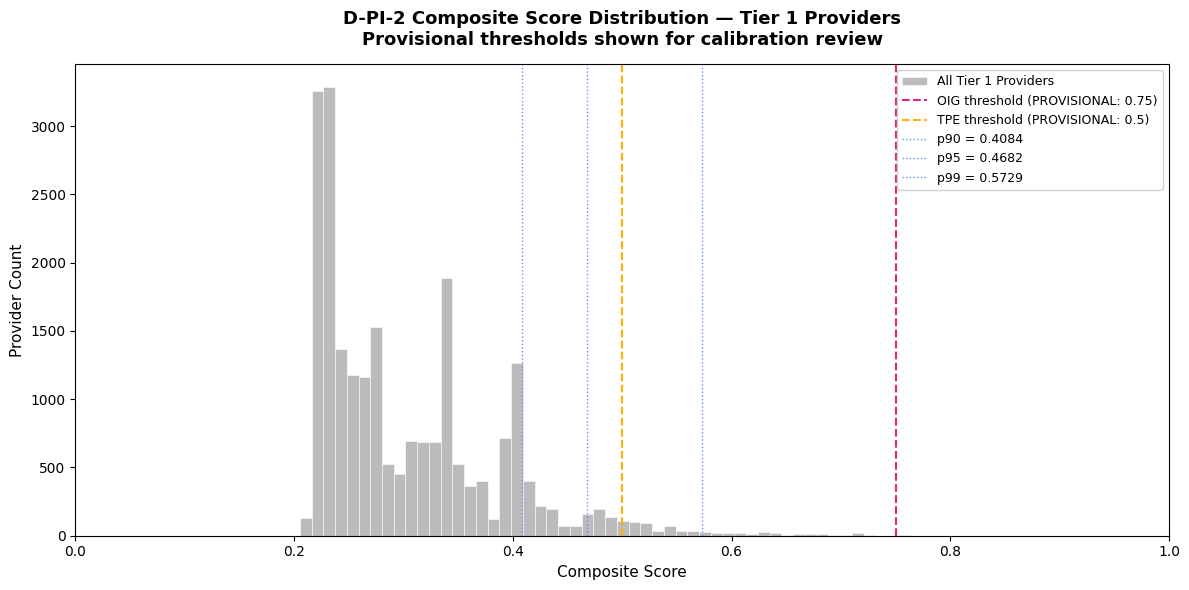

DPI2-07-VIZ-01 complete
  Figure saved : C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\pathway_distribution_v1.png


In [44]:
# DPI2-07-VIZ-01
# Composite score distribution — histogram with percentile markers
# Purpose: Identify natural breaks for OIG and TPE threshold calibration
# Output: pathway_distribution_v1.png
# ---------------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 6))

# ── Histogram ─────────────────────────────────────────────────────
ax.hist(
    df_work['composite_score'],
    bins=60,
    color=CVD_PALETTE['no_flag'],
    edgecolor='white',
    linewidth=0.4,
    label='All Tier 1 Providers'
)

# ── Provisional threshold markers ────────────────────────────────
ax.axvline(THRESHOLD_OIG, color=CVD_PALETTE['tier1_oig'],
           linewidth=1.5, linestyle='--',
           label=f'OIG threshold (PROVISIONAL: {THRESHOLD_OIG})')
ax.axvline(THRESHOLD_TPE, color=CVD_PALETTE['tier2_tpe'],
           linewidth=1.5, linestyle='--',
           label=f'TPE threshold (PROVISIONAL: {THRESHOLD_TPE})')

# ── Percentile markers ────────────────────────────────────────────
key_percentiles = [90, 95, 99]
for p in key_percentiles:
    val = df_work['composite_score'].quantile(p / 100)
    ax.axvline(val, color=CVD_PALETTE['tier3_edltr'],
               linewidth=1.0, linestyle=':',
               label=f'p{p} = {val:.4f}')

# ── Labels and formatting ─────────────────────────────────────────
ax.set_title('D-PI-2 Composite Score Distribution — Tier 1 Providers\n'
             'Provisional thresholds shown for calibration review',
             fontsize=13, fontweight='bold', pad=14)
ax.set_xlabel('Composite Score', fontsize=11)
ax.set_ylabel('Provider Count', fontsize=11)
ax.legend(fontsize=9, framealpha=0.9)
ax.set_xlim(0, 1)

plt.tight_layout()

# ── Save ──────────────────────────────────────────────────────────
fig_path = FIG_OUT / "pathway_distribution_v1.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

print("DPI2-07-VIZ-01 complete")
print(f"  Figure saved : {fig_path}")

<!-- DPI2-06-PATHWAY-00 -->
## Section 06 — Pathway Assignment

Assigns each Tier 1 provider to one of three CMS/UPIC escalation
pathways based on their composite score relative to calibrated
thresholds defined in CONFIG.

| Pathway | Threshold | Action |
|---|---|---|
| OIG/DOJ Referral | composite >= 0.50 | Refer to OIG/DOJ for investigation |
| Targeted Probe and Educate | composite >= 0.40 and < 0.50 | UPIC targeted claims review |
| Provider Education Letter | composite < 0.40 | Administrative education action |

Thresholds calibrated from distribution analysis in DPI2-07-VIZ-01.
Tag: D (Derived).

In [48]:
# DPI2-06-PATHWAY-01
# Pathway assignment — routes each Tier 1 provider to one of three
# CMS/UPIC escalation pathways based on calibrated composite score
# thresholds defined in CONFIG.
# Thresholds: THRESHOLD_OIG=0.50, THRESHOLD_TPE=0.40 (tag: D)
# ---------------------------------------------------------------

def assign_pathway(score):
    if score >= THRESHOLD_OIG:
        return 'OIG/DOJ Referral'
    elif score >= THRESHOLD_TPE:
        return 'Targeted Probe and Educate'
    else:
        return 'Provider Education Letter'

df_work['pathway'] = df_work['composite_score'].apply(assign_pathway)

# ── Pathway counts ────────────────────────────────────────────────
pathway_counts = df_work['pathway'].value_counts()
pathway_pct    = (pathway_counts / len(df_work) * 100).round(2)

print("DPI2-06-PATHWAY-01 — Pathway Assignment")
print("-" * 50)
print(f"  Total providers    : {len(df_work):,}")
print()
print("  Pathway distribution:")
for pathway in ['OIG/DOJ Referral',
                'Targeted Probe and Educate',
                'Provider Education Letter']:
    count = pathway_counts.get(pathway, 0)
    pct   = pathway_pct.get(pathway, 0.0)
    print(f"    {pathway:<35} : {count:>6,}  ({pct:.1f}%)")

print()

# ── Composite score summary by pathway ───────────────────────────
print("  Composite score summary by pathway:")
summary = df_work.groupby('pathway')['composite_score'].agg(
    ['min', 'median', 'max', 'count']
).round(4)
print(summary.to_string())

print()

# ── Assertions ────────────────────────────────────────────────────
assert df_work['pathway'].isnull().sum() == 0, \
    "Null pathway assignments found"
assert set(df_work['pathway'].unique()) <= {
    'OIG/DOJ Referral',
    'Targeted Probe and Educate',
    'Provider Education Letter'
}, "Unexpected pathway values found"

oig_min = df_work.loc[
    df_work['pathway'] == 'OIG/DOJ Referral', 'composite_score'
].min()
tpe_max = df_work.loc[
    df_work['pathway'] == 'Targeted Probe and Educate', 'composite_score'
].max()

assert oig_min >= THRESHOLD_OIG, \
    f"OIG provider below threshold: {oig_min:.4f}"
assert tpe_max < THRESHOLD_OIG, \
    f"TPE provider at or above OIG threshold: {tpe_max:.4f}"

print("DPI2-06-PATHWAY-01 complete — pathway column ready for DPI2-08-OUTPUT-01")

DPI2-06-PATHWAY-01 — Pathway Assignment
--------------------------------------------------
  Total providers    : 22,400

  Pathway distribution:
    OIG/DOJ Referral                    :    655  (2.9%)
    Targeted Probe and Educate          :  2,527  (11.3%)
    Provider Education Letter           : 19,218  (85.8%)

  Composite score summary by pathway:
                               min  median     max  count
pathway                                                  
OIG/DOJ Referral            0.5002  0.5421  0.8496    655
Provider Education Letter   0.2052  0.2626  0.4000  19218
Targeted Probe and Educate  0.4000  0.4145  0.4999   2527

DPI2-06-PATHWAY-01 complete — pathway column ready for DPI2-08-OUTPUT-01


<!-- DPI2-08-OUTPUT-00 -->
## Section 08 — Output

Writes the fully scored and pathway-assigned dataset to processed
parquet files for downstream use.

**escalation_scored_v1.parquet** — full df_work with all dimension
scores, composite score, flag columns, and pathway assignment.

**escalation_pathway_v1.parquet** — lean operational file containing
only the columns required for downstream decision support and
recommendation memo production.

In [49]:
# DPI2-08-OUTPUT-01
# Write scored and pathway-assigned dataset to processed parquet
# Two files: full scored dataset and lean operational pathway file
# ---------------------------------------------------------------

# ── File 1: Full scored dataset ───────────────────────────────────
# Contains all dimension scores, flag columns, composite score,
# and pathway assignment. Full audit trail for all scoring inputs.

df_work.to_parquet(F_SCORED, index=False)

print("DPI2-08-OUTPUT-01 — Output")
print("-" * 50)
print(f"  escalation_scored_v1.parquet written")
print(f"    Rows    : {len(df_work):,}")
print(f"    Columns : {len(df_work.columns)}")
print(f"    Path    : {F_SCORED}")
print()

# ── File 2: Lean operational pathway file ────────────────────────
# Contains only the columns needed for the recommendation memo
# and downstream decision support modules.

pathway_cols = [
    'review_rank',
    'Rndrng_NPI',
    'Rndrng_Prvdr_Type',
    'Rndrng_Prvdr_State_Abrvtn',
    'Rndrng_Prvdr_RUCA',
    'Tot_Benes_sum',
    'allowed_dollars_sum',
    'signals_flagged',
    'composite_score',
    'd1_signal_breadth',
    'd2_signal_type_score',
    'd3_dollar_exposure',
    'd4_persistence_score',
    'pathway',
]

df_pathway = df_work[pathway_cols].copy()
df_pathway.to_parquet(F_PATHWAY, index=False)

print(f"  escalation_pathway_v1.parquet written")
print(f"    Rows    : {len(df_pathway):,}")
print(f"    Columns : {len(df_pathway.columns)}")
print(f"    Path    : {F_PATHWAY}")
print()

# ── Assertions ────────────────────────────────────────────────────
assert F_SCORED.exists(),  f"F_SCORED not found: {F_SCORED}"
assert F_PATHWAY.exists(), f"F_PATHWAY not found: {F_PATHWAY}"

# Verify files round-trip cleanly
df_scored_check  = pd.read_parquet(F_SCORED)
df_pathway_check = pd.read_parquet(F_PATHWAY)

assert len(df_scored_check)  == len(df_work), \
    f"F_SCORED row count mismatch: {len(df_scored_check)}"
assert len(df_pathway_check) == len(df_work), \
    f"F_PATHWAY row count mismatch: {len(df_pathway_check)}"
assert 'pathway' in df_pathway_check.columns, \
    "pathway column missing from F_PATHWAY"
assert 'composite_score' in df_pathway_check.columns, \
    "composite_score column missing from F_PATHWAY"

print(f"  Round-trip verification:")
print(f"    escalation_scored_v1.parquet  : {len(df_scored_check):,} rows  PASS")
print(f"    escalation_pathway_v1.parquet : {len(df_pathway_check):,} rows  PASS")
print()
print("DPI2-08-OUTPUT-01 complete — files written and verified")

DPI2-08-OUTPUT-01 — Output
--------------------------------------------------
  escalation_scored_v1.parquet written
    Rows    : 22,400
    Columns : 34
    Path    : C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed\escalation_scored_v1.parquet

  escalation_pathway_v1.parquet written
    Rows    : 22,400
    Columns : 14
    Path    : C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed\escalation_pathway_v1.parquet

  Round-trip verification:
    escalation_scored_v1.parquet  : 22,400 rows  PASS
    escalation_pathway_v1.parquet : 22,400 rows  PASS

DPI2-08-OUTPUT-01 complete — files written and verified


<!-- DPI2-09-EVIDENCE-00 -->
## Section 09 — Evidence Log

Records all analytical outputs produced by this notebook using the
project O/D/I/A evidence tagging standard.

No outputs in this section assert provider intent, fraud, or wrongdoing.
All outputs describe statistical patterns only.

In [51]:
# DPI2-09-EVIDENCE-01
# Evidence log summary — O/D/I/A tagged outputs from this notebook
# Mirrors entries to be recorded in decisions/D-PI-2_escalation_threshold/evidence_log.md
# ---------------------------------------------------------------

evidence = [
    {
        'id'        : 'E-DPI2-01',
        'source'    : 'df_work — merged from df_queue + interim parquet geo join',
        'cell'      : 'DPI2-03-PREP-00a',
        'result'    : (f'Working dataset: {len(df_work):,} rows, '
                       f'{len(df_work.columns)} columns; zero geo nulls'),
        'tag'       : 'D',
        'relevance' : 'Foundation dataset for all D-PI-2 dimension scoring',
        'status'    : 'Accepted',
    },
    {
        'id'        : 'E-DPI2-02',
        'source'    : 'df_work — D1 through D4 feature columns',
        'cell'      : 'DPI2-03-PREP-01',
        'result'    : (f'D1 mean=0.432 | D2 mean=0.423 | D3 mean=0.208 | D4 mean=0.082; '
                       f'801 D4 neutral assignments (subgroup < {MIN_SUBGROUP_SIZE})'),
        'tag'       : 'D',
        'relevance' : 'Dimension scoring inputs for composite score calculation',
        'status'    : 'Accepted',
    },
    {
        'id'        : 'E-DPI2-03',
        'source'    : 'df_work — composite_score column',
        'cell'      : 'DPI2-05-SCORE-01',
        'result'    : ('Composite scores: min=0.2052 | max=0.8496 | '
                       'mean=0.3035 | median=0.2759 | std=0.0837; '
                       'zero nulls; range fully within [0, 1]'),
        'tag'       : 'D',
        'relevance' : 'Weighted composite risk score for pathway routing',
        'status'    : 'Accepted',
    },
    {
        'id'        : 'E-DPI2-04',
        'source'    : 'pathway_distribution_v1.png',
        'cell'      : 'DPI2-07-VIZ-01',
        'result'    : ('Composite score distribution histogram; natural breaks '
                       'identified at 0.40 (TPE) and 0.50 (OIG); '
                       'THRESHOLD_OIG and THRESHOLD_TPE calibrated (tag: A -> D)'),
        'tag'       : 'D',
        'relevance' : 'Threshold calibration evidence for pathway assignment',
        'status'    : 'Accepted',
    },
    {
        'id'        : 'E-DPI2-05',
        'source'    : 'df_work — pathway column',
        'cell'      : 'DPI2-06-PATHWAY-01',
        'result'    : (
            f"OIG/DOJ Referral: "
            f"{(df_work['pathway'] == 'OIG/DOJ Referral').sum():,} "
            f"({(df_work['pathway'] == 'OIG/DOJ Referral').mean()*100:.1f}%) | "
            f"TPE: "
            f"{(df_work['pathway'] == 'Targeted Probe and Educate').sum():,} "
            f"({(df_work['pathway'] == 'Targeted Probe and Educate').mean()*100:.1f}%) | "
            f"Education Letter: "
            f"{(df_work['pathway'] == 'Provider Education Letter').sum():,} "
            f"({(df_work['pathway'] == 'Provider Education Letter').mean()*100:.1f}%)"
        ),
        'tag'       : 'D',
        'relevance' : 'Three-pathway escalation routing for D-PI-1 Tier 1 providers',
        'status'    : 'Accepted',
    },
    {
        'id'        : 'E-DPI2-06',
        'source'    : 'escalation_scored_v1.parquet / escalation_pathway_v1.parquet',
        'cell'      : 'DPI2-08-OUTPUT-01',
        'result'    : ('Two parquet files written and round-trip verified; '
                       '22,400 rows each; scored: 34 columns | pathway: 14 columns'),
        'tag'       : 'D',
        'relevance' : 'Persistent outputs for recommendation memo and downstream modules',
        'status'    : 'Accepted',
    },
]

print("DPI2-09-EVIDENCE-01 — Evidence Log Summary")
print("-" * 50)
for e in evidence:
    print(f"  {e['id']}  [{e['tag']}]  {e['cell']}")
    print(f"    Result   : {e['result']}")
    print(f"    Relevance: {e['relevance']}")
    print(f"    Status   : {e['status']}")
    print()

print("DPI2-09-EVIDENCE-01 complete — transcribe entries to evidence_log.md")

DPI2-09-EVIDENCE-01 — Evidence Log Summary
--------------------------------------------------
  E-DPI2-01  [D]  DPI2-03-PREP-00a
    Result   : Working dataset: 22,400 rows, 34 columns; zero geo nulls
    Relevance: Foundation dataset for all D-PI-2 dimension scoring
    Status   : Accepted

  E-DPI2-02  [D]  DPI2-03-PREP-01
    Result   : D1 mean=0.432 | D2 mean=0.423 | D3 mean=0.208 | D4 mean=0.082; 801 D4 neutral assignments (subgroup < 10)
    Relevance: Dimension scoring inputs for composite score calculation
    Status   : Accepted

  E-DPI2-03  [D]  DPI2-05-SCORE-01
    Result   : Composite scores: min=0.2052 | max=0.8496 | mean=0.3035 | median=0.2759 | std=0.0837; zero nulls; range fully within [0, 1]
    Relevance: Weighted composite risk score for pathway routing
    Status   : Accepted

  E-DPI2-04  [D]  DPI2-07-VIZ-01
    Result   : Composite score distribution histogram; natural breaks identified at 0.40 (TPE) and 0.50 (OIG); THRESHOLD_OIG and THRESHOLD_TPE calibrated (tag